In [1]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)

In [3]:
base_path = "/home/jinjinjara1022/"

# weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_1.csv")
# weather_forecast_data_2 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_2.csv")  

# weather_observed_data_1 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_1.csv")
# weather_observed_data_2 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_2.csv")  
  
jeju_power_market_day_ahead = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_하루전가격.csv")
jeju_power_market_real_time = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_실시간가격.csv")

# jeju_power_market_status = pd.read_csv(base_path + "OBIC/data/제주전력시장_현황데이터.csv")

In [4]:
df = jeju_power_market_day_ahead

df['datetimes'] = pd.to_datetime(df['ts'], unit='s')
df['hour'] = df['datetimes'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['month'] = df['datetimes'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['day_of_week'] = df['datetimes'].dt.dayofweek
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)


df = df.drop(['datetimes', 'ts', 'hour', 'month', 'day_of_week'], axis=1)
df = df[[col for col in df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]

df.rename(columns={
    '하루전가격(원/kWh)': 'previous_price_kwh'
}, inplace=True)

In [5]:
df['previous_hour_price'] = df['previous_price_kwh'].shift(1)
df['previous_hour_price'] = df['previous_price_kwh'].shift(2)
df['previous_hour_price'] = df['previous_price_kwh'].shift(3)
df['previous_day_price'] = df['previous_price_kwh'].shift(24)
df['previous_2day_price'] = df['previous_price_kwh'].shift(48)
df['previous_2day_price'] = df['previous_price_kwh'].shift(72)

In [6]:
df = df[72:]

In [7]:
df

,hour_sin,hour_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,previous_price_kwh,previous_hour_price,previous_day_price,previous_2day_price
72,-7.071068e-01,-7.071068e-01,1.000000,6.123234e-17,-0.781831,0.62349,170.79,171.26,247.14,107.39
73,-8.660254e-01,-5.000000e-01,1.000000,6.123234e-17,-0.781831,0.62349,168.30,175.61,321.47,107.39
74,-9.659258e-01,-2.588190e-01,1.000000,6.123234e-17,-0.781831,0.62349,86.82,175.61,100.21,95.30
75,-1.000000e+00,-1.836970e-16,1.000000,6.123234e-17,-0.781831,0.62349,80.97,170.79,82.66,87.89
76,-9.659258e-01,2.588190e-01,1.000000,6.123234e-17,-0.781831,0.62349,80.97,168.30,82.66,0.00
...,...,...,...,...,...,...,...,...,...,...
5660,2.588190e-01,-9.659258e-01,-0.866025,5.000000e-01,0.781831,0.62349,156.68,155.95,158.38,139.29
5661,1.224647e-16,-1.000000e+00,-0.866025,5.000000e-01,0.781831,0.62349,152.54,157.25,157.18,102.23
5662,-2.588190e-01,-9.659258e-01,-0.866025,5.000000e-01,0.781831,0.62349,106.92,156.68,105.63,99.11
5663,-5.000000e-01,-8.660254e-01,-0.866025,5.000000e-01,0.781831,0.62349,150.97,156.68,157.56,93.02


In [8]:
y = df['previous_price_kwh']
x = df.drop('previous_price_kwh', axis=1)

In [10]:
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = int(len(y) * 0.1))
print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

train data shape
x:(5034, 9), y:(5034,)


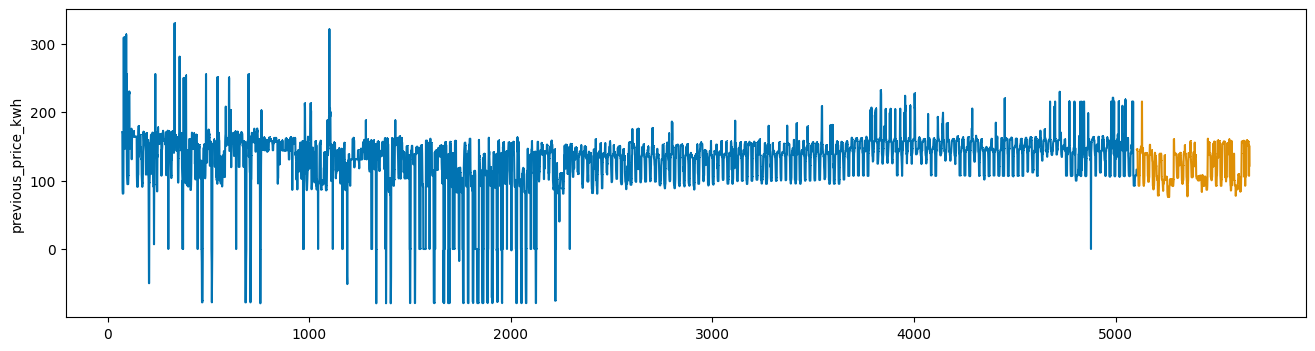

In [11]:
plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

In [12]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [13]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [14]:
import xgboost as xgb
print(xgb.__version__)


2.1.1


In [15]:
from xgboost import XGBRegressor

# XGBRegressor 모델 생성 (GPU 사용)
xgb_reg = XGBRegressor(
    n_estimators=2000, 
    learning_rate=0.01,      # 학습률
    min_child_weight=1,      # 최소 가중치
    max_depth=7,             # 최대 깊이
    colsample_bytree=0.8,    # 컬럼 샘플링 비율
    subsample=0.8,           # 데이터 샘플링 비율
    tree_method='hist',      # 'hist' 사용
    device='cuda',           # GPU 사용 설정
    seed=0,
    early_stopping_rounds = 300
)

xgb_reg.fit(
    x_train, y_train, 
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=300,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
x_valid

,hour_sin,hour_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,previous_hour_price,previous_day_price,previous_2day_price
5106,7.071068e-01,-0.707107,-1.000000,-1.836970e-16,-0.781831,0.62349,107.65,215.53,209.35
5107,5.000000e-01,-0.866025,-1.000000,-1.836970e-16,-0.781831,0.62349,116.06,146.94,146.82
5108,2.588190e-01,-0.965926,-1.000000,-1.836970e-16,-0.781831,0.62349,116.06,144.72,167.19
5109,1.224647e-16,-1.000000,-1.000000,-1.836970e-16,-0.781831,0.62349,145.61,144.51,167.19
5110,-2.588190e-01,-0.965926,-1.000000,-1.836970e-16,-0.781831,0.62349,146.02,141.38,144.89
...,...,...,...,...,...,...,...,...,...
5660,2.588190e-01,-0.965926,-0.866025,5.000000e-01,0.781831,0.62349,155.95,158.38,139.29
5661,1.224647e-16,-1.000000,-0.866025,5.000000e-01,0.781831,0.62349,157.25,157.18,102.23
5662,-2.588190e-01,-0.965926,-0.866025,5.000000e-01,0.781831,0.62349,156.68,105.63,99.11
5663,-5.000000e-01,-0.866025,-0.866025,5.000000e-01,0.781831,0.62349,156.68,157.56,93.02


In [17]:
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)

/home/jinjinjara1022/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:18] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


SMAPE : 5.403004638495061


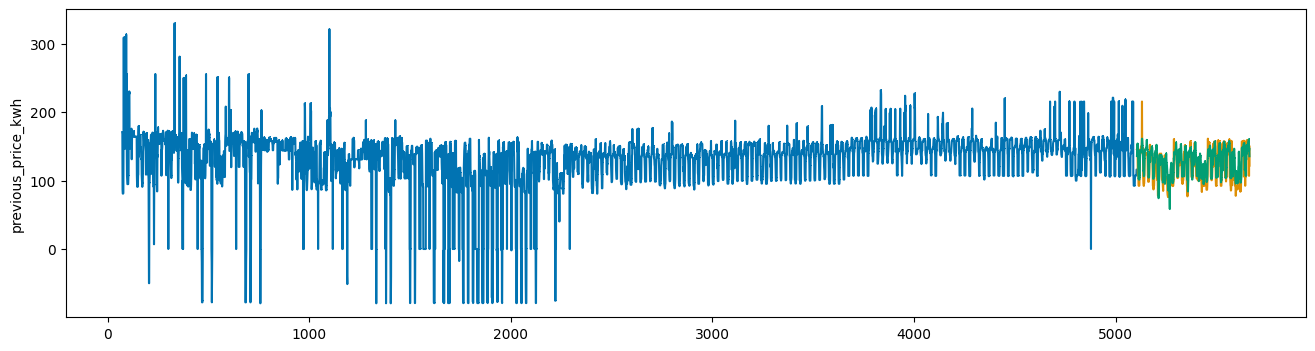

In [18]:
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

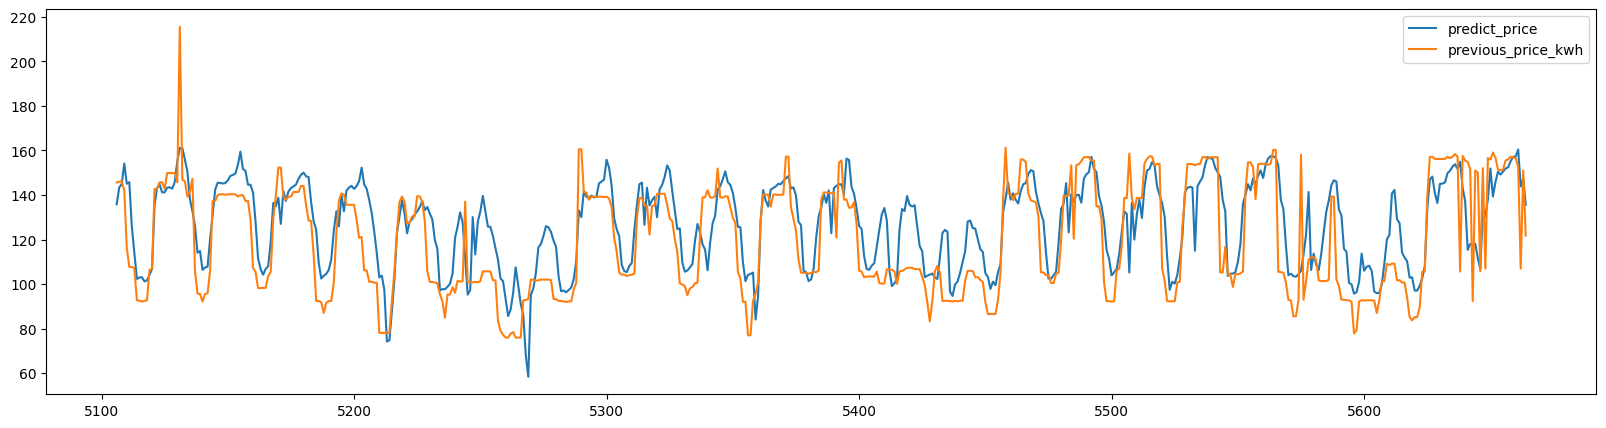

In [19]:
plt.figure(figsize=(20, 5))
pred.plot(label='predict_price')
y_valid.plot()
plt.legend()
plt.show()

### Evaluate

In [20]:
x_valid

,hour_sin,hour_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,previous_hour_price,previous_day_price,previous_2day_price
5106,7.071068e-01,-0.707107,-1.000000,-1.836970e-16,-0.781831,0.62349,107.65,215.53,209.35
5107,5.000000e-01,-0.866025,-1.000000,-1.836970e-16,-0.781831,0.62349,116.06,146.94,146.82
5108,2.588190e-01,-0.965926,-1.000000,-1.836970e-16,-0.781831,0.62349,116.06,144.72,167.19
5109,1.224647e-16,-1.000000,-1.000000,-1.836970e-16,-0.781831,0.62349,145.61,144.51,167.19
5110,-2.588190e-01,-0.965926,-1.000000,-1.836970e-16,-0.781831,0.62349,146.02,141.38,144.89
...,...,...,...,...,...,...,...,...,...
5660,2.588190e-01,-0.965926,-0.866025,5.000000e-01,0.781831,0.62349,155.95,158.38,139.29
5661,1.224647e-16,-1.000000,-0.866025,5.000000e-01,0.781831,0.62349,157.25,157.18,102.23
5662,-2.588190e-01,-0.965926,-0.866025,5.000000e-01,0.781831,0.62349,156.68,105.63,99.11
5663,-5.000000e-01,-0.866025,-0.866025,5.000000e-01,0.781831,0.62349,156.68,157.56,93.02


In [21]:
input1 = x_valid.iloc[10].to_numpy()
preds = []

# Initial prediction for the first entry
pred1 = float(xgb_reg.predict([input1])[0])
preds.append(pred1)

# Loop for the next 23 predictions
for i in range(11, 34):
    input_i = x_valid.iloc[i].to_numpy()
    input_i[-3] = preds[-1]  # Update the third-last feature with the previous prediction
    pred_i = float(xgb_reg.predict([input_i])[0])
    preds.append(pred_i)

In [22]:
def gg(st):
    input1 = x_valid.iloc[st].to_numpy()
    preds = []
    
    # Initial prediction for the first entry
    pred1 = float(xgb_reg.predict([input1])[0])
    preds.append(pred1)
    
    # Loop for the next 23 predictions
    for i in range(st+1, st+25):
        input_i = x_valid.iloc[i].to_numpy()
        input_i[-3] = preds[-1]  # Update the third-last feature with the previous prediction
        pred_i = float(xgb_reg.predict([input_i])[0])
        preds.append(pred_i)

    reals = y_valid[st-25:st+25].to_numpy()
    adjusted_preds = np.concatenate((np.full(25, np.nan), preds))

    plt.plot(adjusted_preds, label='predict price')
    plt.plot(reals, label='real price')
    plt.legend()
    plt.show()
        

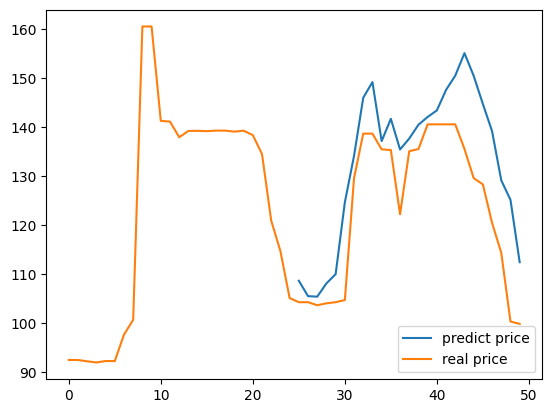

In [25]:
gg(200)